# **0. Install Depedencies**

In [2]:
!pip install transformers==3.1.0

     |████████████████████████████████| 890kB 7.5MB/s 
     |████████████████████████████████| 3.0MB 15.7MB/s 
     |████████████████████████████████| 1.2MB 49.3MB/s 
     |████████████████████████████████| 901kB 31.6MB/s 


# **1. Import Libraries**


In [3]:
#Import libraries
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertForSequenceClassification

import tensorflow as tf

In [4]:
#Some libraries from APLOD-Net V1.0
#from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import pandas as pd
import numpy as np

# **2. EDA (Exploratory Data Analysis)**

In [5]:
df = pd.read_csv('Twitter.csv')
df.head()

FileNotFoundError: ignored

In [5]:
text = df['Tweet'].tolist()
print(len(text))

10806


In [6]:
output = df['sentimen']
output_converted = to_categorical(output)
print(output_converted)

[[0. 0. 1.]
 [0. 0. 1.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [7]:
df['sentimen'].value_counts()

0    5327
2    2887
1    2592
Name: sentimen, dtype: int64

In [31]:
df['Tweet'].astype(str).astype(int)

ValueError: ignored

In [16]:
import json

TRAINING_SIZE = 10000

#with open("Tweet.json", 'r') as f:
    #datastore = json.load(f)
#def convert_tweet_to_int(my_dict):
    #my_dict['Tweet'] = int(my_dict['Tweet'])
    #return my_dict

with open("Tweet.json", 'r') as f:
    datastore = json.load(f)

#result = json.loads(my_json_str, object_hook=convert_class_to_int)
#print(datastore)

sentences = []
labels = []

for items in datastore :
  sentences.append(items['Tweet'])
  labels.append(items['sentimen'])

training_sentences = sentences[0:TRAINING_SIZE]
validation_sentences = sentences[TRAINING_SIZE:]
training_labels = labels[0:TRAINING_SIZE]
validation_labels = labels[TRAINING_SIZE:]

In [17]:
print(len(training_sentences))
print(len(validation_sentences))

10000
806


# **3. Setup BERT and Train the Model**

In [18]:
#Assign the tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [19]:
#Do the encodings of training sentences and validation sentences
train_encodings = tokenizer(training_sentences, truncation= True, padding= True)
val_encodings = tokenizer(validation_sentences, truncation= True, padding = True)

In [20]:
#Create TF Dataset and Map the dataset to labels
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    training_labels
))

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    validation_labels
))

In [21]:
#Assign the Model
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = 3)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_projector', 'vocab_transform', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier', 'classifier', 'dropout_19']
You should probably TRAIN this model on a down-stream task to be able to use i

In [23]:
#Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
model.compile(optimizer=optimizer, loss=model.compute_loss, metrics=['accuracy'])
history = model.fit(train_dataset.shuffle(100).batch(16),
          epochs=100,
          batch_size=16,
          validation_data=val_dataset.shuffle(100).batch(16))

Epoch 1/100
625/625 [==============================] - 76s 111ms/step - loss: 0.4739 - accuracy: 0.8108 - val_loss: 1.0453 - val_accuracy: 0.5819
Epoch 2/100
625/625 [==============================] - 68s 109ms/step - loss: 0.3400 - accuracy: 0.8692 - val_loss: 1.3282 - val_accuracy: 0.5757
Epoch 3/100
625/625 [==============================] - 68s 109ms/step - loss: 0.2562 - accuracy: 0.9059 - val_loss: 1.4262 - val_accuracy: 0.5955
Epoch 4/100
625/625 [==============================] - 68s 109ms/step - loss: 0.2287 - accuracy: 0.9165 - val_loss: 1.4363 - val_accuracy: 0.5918
Epoch 5/100
625/625 [==============================] - 68s 109ms/step - loss: 0.1991 - accuracy: 0.9266 - val_loss: 1.6969 - val_accuracy: 0.5732
Epoch 6/100
625/625 [==============================] - 68s 109ms/step - loss: 0.1830 - accuracy: 0.9347 - val_loss: 1.4880 - val_accuracy: 0.6117
Epoch 7/100
625/625 [==============================] - 68s 108ms/step - loss: 0.1682 - accuracy: 0.9402 - val_loss: 1.9324 -

# **4. Visualization**

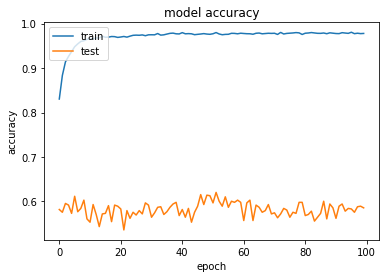

In [25]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [26]:
#Saved The Model
model.save_pretrained("/tmp/sentiment_custom_model")

# **5. Load saved Model and do the prediction**

In [27]:
loaded_model = TFDistilBertForSequenceClassification.from_pretrained("/tmp/sentiment_custom_model")

Some weights of the model checkpoint at /tmp/sentiment_custom_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at /tmp/sentiment_custom_model and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
test_sentence = "Anjing kau bangsat. idiot kaya gapernah disekolahin lu njing" #ini gw dapat dari twitter ya ges ehehehe
# replace to test_sentence variable, if you want to test the model
predict_input = tokenizer.encode(test_sentence,
                                 truncation=True,
                                 padding=True,
                                 return_tensors="tf")

tf_output = loaded_model.predict(predict_input)[0]
print(tf_output)

[[-4.473761  -6.9954104  5.6168866]]


In [39]:
tf_prediction = tf.nn.softmax(tf_output, axis=1).numpy()[0]
print(tf_prediction)

# 4.1463685e-05 = 0.00004146368
# 2.1356659e-04 = 0.00000333065
# 9.9995518e-01 = 0.99995518
# => sentiment = 2 (negative)
# nb : 0 = neutral , 1 = positive , 2 = negative

[4.1463685e-05 3.3306540e-06 9.9995518e-01]
